# Ch. 6 - Minibatch Gradient Descent
Before you head of into the challenge, there is one more topic we need to cover: [Minibatches](https://stats.stackexchange.com/questions/117919/what-are-the-differences-between-epoch-batch-and-minibatch).

So far we have used our entire training set at once to train our models. That worked fine as long as we had only 200 or so examples. But as we saw in chapter 1, machine learning works best with massive datasets with hundreds of thousands or even millions of examples. To train the neural network for Face ID on the iPhone, apple used over [a billion images of faces](https://images.apple.com/business/docs/FaceID_Security_Guide.pdf). No computer has the memory capacity to process a billion images at once, so in order to make training on larger sets feasible we need to divide the training set into smaller 'minibatches'.

In this chapter we will have a look at how to implement minibatch gradient descent. 

** Warning: Since we will start working with large amounts of data now, this might no longer work on your laptop. Run this notebook on a cloud computing instance with more RAM and CPUs**

As it is custom, we will load all our libraries first and define the decision boundary helper method first

In [1]:
# Package imports
# Matplotlib is a matlab like plotting library
import matplotlib
import matplotlib.pyplot as plt
# Numpy handles matrix operations
import numpy as np
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates decision boundary plot
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=1,c=y, cmap=plt.cm.Accent)

Now we will generate a dataset with 10,000 examples. This should be enough to showcase the concept while still working with reasonable resources.

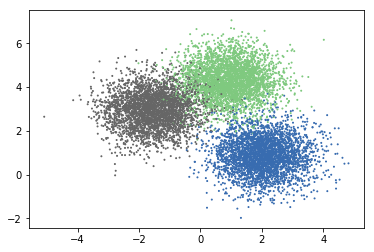

In [3]:
# Generate a BIG dataset and plot it
# This might take a little while
num_samples = 10000
np.random.seed(0)
X, y = sklearn.datasets.make_blobs(n_samples=num_samples,centers=3,cluster_std=0.8)
# We will make the points a little bit smaller so that the graph is more clear
plt.scatter(X[:,0], X[:,1], s=1, c=y, cmap=plt.cm.Accent)

As you can see, the problem is the same as in the last chapter. We need to separate three groups of customers. But this time around we have a lot more customers. 

In [4]:
# Generate one hot encoding

# Reshape from array to vector
y = y.reshape(num_samples,1)
# Generate one hot encoding
enc = OneHotEncoder()
onehot = enc.fit_transform(y)
# Convert to numpy vector
y = onehot.toarray()

## Generating minibatches
A minibatch is a randomly drawn subset of the training set. We will define a method to create an array of these subsets we can loop over.

In [5]:
def get_mini_batches(X, y, batch_size):
    '''
    Generates an array of randomly drawn minibatches.
    '''
    # First we shuffle the training data so that it is later easier to draw random samples from it
    # Generate random indexes, sampeled without replacement
    random_idxs = np.random.choice(len(y), len(y), replace=False)
    # Generate a shuffled version of the examples in X
    X_shuffled = X[random_idxs,:]
    # Generate a shuffeled version of the targets in y
    # Note that since we use the same random indexes for X and y the example and the targets will still match
    y_shuffled = y[random_idxs]
    # List statements to move through set and sample batches
    mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                   i in range(0, len(y), batch_size)]
    return mini_batches

We have now defined a helper function that can generate a set of minibatches from our training set. Note that the batches get randomly drawn _without replacement_. It has been shown that this leads to [faster learning](https://stats.stackexchange.com/questions/235844/should-training-samples-randomly-drawn-for-mini-batch-training-neural-nets-be-dr). Now we need to incorporate the minibatch method into our training function. The other functions of our neural net stay unaffected so we are going to define them here now before moving to the training function.

In [6]:
def softmax(z):
    '''
    Calculates the softmax activation of a given input x
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def softmax_loss(y,y_hat):
    '''
    Calculates the generalized logistic loss between a prediction y_hat and the labels y
    See: http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/

    We need to clip values that get too close to zero to avoid zeroing out. 
    Zeroing out is when a number gets so small that the computer replaces it with 0.
    Therefore, we clip numbers to a minimum value.
    '''
    # Clipping calue
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss

# Log loss derivative, equal to softmax loss derivative
def loss_derivative(y,y_hat):
    '''
    Calculates the gradient (derivative) of the loss between point y and y_hat
    See: https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
    '''
    return (y_hat-y)

def tanh_derivative(x):
    '''
    Calculates the derivative of the tanh function that is used as the first activation function
    See: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    '''
    return (1 - np.power(x, 2))

def forward_prop(model,a0):
    '''
    Forward propagates through the model, stores results in cache.
    See: https://stats.stackexchange.com/questions/147954/neural-network-forward-propagation
    A0 is the activation at layer zero, it is the same as X
    '''
    
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Linear step
    z1 = a0.dot(W1) + b1
    
    # First activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = softmax(z2)
    cache = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2}
    return cache

def backward_prop(model,cache,y):
    '''
    Backward propagates through the model to calculate gradients.
    Stores gradients in grads dictionary.
    See: https://en.wikipedia.org/wiki/Backpropagation
    '''
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Load forward propagation results
    a0,a1, a2 = cache['a0'],cache['a1'],cache['a2']
    
    # Get number of samples
    m = y.shape[0]
    
    # Backpropagation
    # Calculate loss derivative with respect to output
    dz2 = loss_derivative(y=y,y_hat=a2)
   
    # Calculate loss derivative with respect to second layer weights
    dW2 = 1/m*(a1.T).dot(dz2)
    
    # Calculate loss derivative with respect to second layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz1 = np.multiply(dz2.dot(W2.T) ,tanh_derivative(a1))
    
    # Calculate loss derivative with respect to first layer weights
    dW1 = 1/m*np.dot(a0.T, dz1)
    
    # Calculate loss derivative with respect to first layer bias
    db1 = 1/m*np.sum(dz1, axis=0)
    
    # Store gradients
    grads = {'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

def initialize_parameters(nn_input_dim,nn_hdim,nn_output_dim):
    '''
    Initializes weights with random number between -1 and 1
    Initializes bias with 0
    Assigns weights and parameters to model
    '''
    # First layer weights
    W1 = 2 *np.random.randn(nn_input_dim, nn_hdim) - 1
    
    # First layer bias
    b1 = np.zeros((1, nn_hdim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_output_dim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, nn_output_dim))
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

def update_parameters(model,grads,learning_rate):
    '''
    Updates parameters accoarding to gradient descent algorithm
    See: https://en.wikipedia.org/wiki/Gradient_descent
    '''
    # Load parameters
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    
    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

def predict(model, x):
    '''
    Predicts y_hat as 1 or 0 for a given input X
    '''
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = np.argmax(c['a2'], axis=1)
    return y_hat

## Minibatches in training
In training, we loop over forward and backward propagation multiple times to optimize the model parameters. So far, we have used the entire training set. Since we now have multiple batches, it means we have to add another loop, to loop over all the batches in one epoch. By using minibatches, we also add a new hyperparameter, the minibatch size, that is, how many examples should be in one minibatch.

In [7]:
def train(model,X_,y_,learning_rate, batch_size = 32, epochs=20000, print_loss=False):
    # Generate minibatches:
    minibatches = get_mini_batches(X=X_,y=y_,batch_size=batch_size)
    
    # Set up loss tracking array, will hold losses for each minibatch
    losses = []
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):
        
        # Loop through the minibatches
        for mb in minibatches:
            # Get examples
            X_mb = mb[0]
            # Get targets
            y_mb = mb[1]
            # Forward propagation
            cache = forward_prop(model,X_mb)
            #a1, probs = cache['a1'],cache['a2']
            # Backpropagation

            grads = backward_prop(model,cache,y_mb)
            # Gradient descent parameter update
            # Assign new parameters to the model
            model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
            # Track losses
            a2 = cache['a2']
            loss = softmax_loss(y_mb,a2)
            losses.append(loss)
        # Pring loss & accuracy every 100 iterations
        if print_loss and i % 100 == 0:
            a2 = cache['a2']
            print('Loss after iteration',i,':',softmax_loss(y_mb,a2))
            y_hat = predict(model,X_)
            y_true = y.argmax(axis=1)
            print('Accuracy after iteration',i,':',accuracy_score(y_pred=y_hat,y_true=y_true)*100,'%')
    
    return model, losses

In [8]:
# Hyper parameters
hiden_layer_size = 3
# I picked this value because it showed good results in my experiments
learning_rate = 0.01
# Small mini batch size
batch_size = 32

In [9]:
# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 3)
model, losses = train(model,X,y,learning_rate=learning_rate,batch_size=batch_size,epochs=1000,print_loss=True)

Loss after iteration 0 : 1.030747851668526
Accuracy after iteration 0 : 37.51 %
Loss after iteration 100 : 0.20177289162603976
Accuracy after iteration 100 : 96.28999999999999 %
Loss after iteration 200 : 0.1316042923571346
Accuracy after iteration 200 : 96.34 %
Loss after iteration 300 : 0.1291601442343249
Accuracy after iteration 300 : 96.32 %
Loss after iteration 400 : 0.1276764877424481
Accuracy after iteration 400 : 96.34 %
Loss after iteration 500 : 0.1268193585978512
Accuracy after iteration 500 : 96.35000000000001 %
Loss after iteration 600 : 0.12629617253625874
Accuracy after iteration 600 : 96.37 %
Loss after iteration 700 : 0.12596084604364044
Accuracy after iteration 700 : 96.37 %
Loss after iteration 800 : 0.12574062855870619
Accuracy after iteration 800 : 96.36 %
Loss after iteration 900 : 0.1255956736409626
Accuracy after iteration 900 : 96.36 %


As you can see, our model now can learn on the much bigger dataset without draining too much memory. In fact, it has achieved even better results than before because it now has more data to work with. We can confirm this by plotting the decision boundary again.

Text(0.5,1,'Decision Boundary for hidden layer size 3')

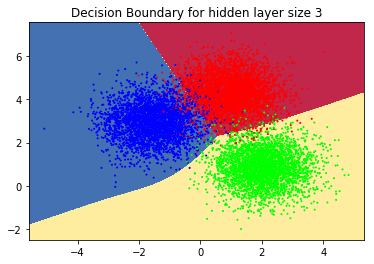

In [10]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model,x))
plt.title("Decision Boundary for hidden layer size 3")

## Minibatches and noisy training
If we pay close attention to how our model learns now, we see that the loss decay has become a lot more noisy.

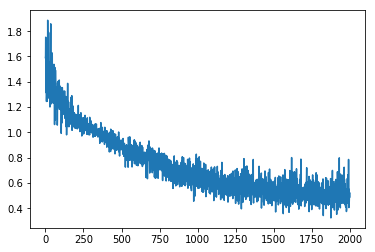

In [11]:
plt.plot(losses[:2000])

The noise comes from the fact that the smaller batches might be statistically different from the larger training set. It can therefore be a good idea to adjust the learning rate a bit to make sure that an outlier minibatch does not move the model all too much.

In [12]:
# Hyper parameters
hiden_layer_size = 3
# Smaller learning rate for minibatches
learning_rate = 0.001
# Small mini batch size
batch_size = 32

In [13]:
# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 3)
model, losses = train(model,X,y,learning_rate=learning_rate,batch_size=batch_size,epochs=1000,print_loss=True)

Loss after iteration 0 : 1.225596306145859
Accuracy after iteration 0 : 33.54 %
Loss after iteration 100 : 0.39063281523148574
Accuracy after iteration 100 : 82.98 %
Loss after iteration 200 : 0.24347401211882283
Accuracy after iteration 200 : 95.54 %
Loss after iteration 300 : 0.23835152110526003
Accuracy after iteration 300 : 95.89 %
Loss after iteration 400 : 0.23553113435368223
Accuracy after iteration 400 : 96.0 %
Loss after iteration 500 : 0.23380111860680555
Accuracy after iteration 500 : 96.12 %
Loss after iteration 600 : 0.23225614705500947
Accuracy after iteration 600 : 96.17 %
Loss after iteration 700 : 0.23018250253729358
Accuracy after iteration 700 : 96.27 %
Loss after iteration 800 : 0.22650260674040337
Accuracy after iteration 800 : 96.26 %
Loss after iteration 900 : 0.21943504212671264
Accuracy after iteration 900 : 96.26 %


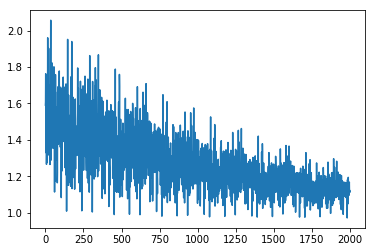

In [14]:
plt.plot(losses[:2000])

As you can see, the smaller learning rate here helps to smoothen the process. You might also want to try out what happens to training speed and the movement of losses if you adjust the batch size.

## Summary
In this case you saw minibatch gradient descent. It allows us to work with much larger datasets. You now have all the tools ready for this weeks challenge. Good luck!

This week was quite math heavy, and understanding how a neural network works from scratch has a big learning curve. The fact that you have made it so far is a hughe accomplishment, congratulations! If you still find yourself a bit confused don't worry, so did I when I started out. This weeks challenge is meant to give you a better understanding by having you implement and tweak a neural network from scratch. It can also help to watch some youtube videos that other people made. Here are some of my favorite ones:
- [What *is* a neural network by 3blue1brown](https://www.youtube.com/watch?v=aircAruvnKk)
- [A friendly introduction to Deep Learning and Neural Networks by Luis Serrano](https://www.youtube.com/watch?v=BR9h47Jtqyw)
- [Intro to Deep Learning by Siraj Raval](https://www.youtube.com/watch?v=vOppzHpvTiQ)

I hope you found this weeks content useful. If you found a mistake, something was poorly explained or you think it could be done better, please file an issue on [GitHub](https://github.com/JannesKlaas/MLiFC). Thank you for using this material.